In [1]:
import sys

sys.path.append("../")

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter

from semd.proc.tde_2d.process import TDE2D
from semd.proc.reshape_conv.process import ReshapeConv
from semd.proc.change_dim.process import ChangeDim
from semd.proc.add_dim.process import AddDim
from semd.proc.sel_exp.process import SelExp

from lava.proc.lif.process import LIF
from lava.magma.core.process.process import AbstractProcess
from lava.magma.core.process.ports.ports import InPort, OutPort
from lava.magma.core.process.variable import Var
from lava.magma.core.model.sub.model import AbstractSubProcessModel

from lava.proc.io.source import RingBuffer
from lava.proc.io.sink import RingBuffer as SinkBuffer
from lava.proc.monitor.process import Monitor

from lava.magma.core.run_configs import RunConfig, Loihi1SimCfg
from lava.magma.core.run_conditions import RunSteps

import semd2d_utils

events = np.loadtxt("../data_processed/events_refact_circ05.txt")
directions = np.loadtxt("active_dir.txt")
# this data is already filtered by time, no need to redo it here

# use only the specified patch of input events
patch_center = (90, 120)
patch_size = 180
events = semd2d_utils.filter_patch(events, patch_center, patch_size)

data_steps = 50 # timesteps to divide the data into
sim_steps = 50 # simulation steps
shape = (patch_size, patch_size)
t_start = events[0, 0]
duration = events[-1, 0] - events[0, 0]
n_directions = 16

input_directions = np.zeros((n_directions, data_steps))
for t in range(data_steps):
    
    t_real = t_start + t * (duration / data_steps)
    
    t_dif = t_real - directions[:,0]
    t_dif_m = np.ma.masked_where(t_dif < 0, t_dif)
    
    idx = t_dif_m.argmin()

    input_directions[int(directions[idx, 1]), t] = 1

directions_n = RingBuffer(input_directions)

output_dir = SinkBuffer(shape=(n_directions,), buffer=sim_steps)
directions_n.s_out.connect(output_dir.a_in)

args = {
    "shape":shape,
    "conv_shape": (2, 2),
    "conv_stride": (1, 1),
    "thresh_conv": 0.5,
    "detector_du": 0.1
}

vth = 10
conv_shape = args["conv_shape"]
conv_stride = args["conv_stride"]
thresh_conv = args["thresh_conv"]
detector_dv = 0.2

input_data = semd2d_utils.gen_input_data(events, shape, data_steps)
input_n = RingBuffer(input_data)

bias_weight = (vth / (conv_shape[0] * conv_shape[1])) / thresh_conv
# convolution layer with reshape proc
conv = ReshapeConv(input_shape=shape, conv_shape=conv_shape, conv_stride=conv_stride,
                        bias_weight=bias_weight)

out_shape = conv.out_shape
# connect the input to the convolution
input_n.s_out.connect(conv.in_ports.s_in)

output_n = SinkBuffer(shape=out_shape, buffer=sim_steps)

# lif layer that collects the value from the convolution layer and fires when enough neuron in the input fire
lif = LIF(shape=out_shape, du=1.0, dv=0.0, vth=10.0)

# conv to lif
conv.s_out.connect(lif.a_in)

dirs_list = [
    [3, 0], [3, 1], [2, 2], [1, 3], [0, 3], [-1, 3], [-2, 2], [-3, 1], [-3,0], [-3, -1], [-2,-2],
    [-1,-3], [0,-3], [1,-3], [2,-2], [3,-1]
]

change_dim_excit_list = [None] * n_directions
change_dim_trig_list = [None] * n_directions
detector_list = [None] * n_directions
add_dim_list = [None] * n_directions
sel_exp_list = [None] * n_directions

for i, dir in enumerate(dirs_list[:]):
    detector_shape = (out_shape[0] - np.abs(dir[1]), out_shape[1] - np.abs(dir[0]))

    if dir[0] > 0:
        col_del_excit = np.arange(-dir[0], 0)
    else:
        col_del_excit = np.arange(0, -dir[0])

    if dir[1] > 0:
        row_del_excit = np.arange(-dir[1], 0)
    else:
        row_del_excit = np.arange(0, -dir[1])

    if dir[0] > 0:
        col_del_trig = np.arange(0, dir[0])
    else:
        col_del_trig = np.arange(dir[0], 0)

    if dir[1] > 0:
        row_del_trig = np.arange(0, dir[1])
    else:
        row_del_trig = np.arange(dir[1], 0)

    # removes columns and row from the lif to match the dimension of the time difference detector
    # change_dim_excit = ChangeDim(shape=(out_shape), col_del=col_del_excit, row_del=row_del_excit, weight=11.0)
    change_dim_excit_list[i] = ChangeDim(shape=(out_shape), col_del=col_del_excit, row_del=row_del_excit, weight=4.0)
    change_dim_trig_list[i] = ChangeDim(shape=(out_shape), col_del=col_del_trig, row_del=row_del_trig)

    # time difference detector for the left motion
    detector_list[i] = TDE2D(shape=detector_shape, dv=detector_dv, du=1)

    sel_exp_list[i] = SelExp(shape_in=(n_directions,), out_r=detector_shape[0], out_c=detector_shape[1], weight=6, sel_id=i)
    directions_n.s_out.connect(sel_exp_list[i].s_in)
    sel_exp_list[i].s_out.connect(detector_list[i].a_in)

    add_dim_list[i] = AddDim(in_shape=detector_shape, out_shape=out_shape, dis_x=dir[0], dis_y=dir[1])

    lif.s_out.connect(change_dim_excit_list[i].s_in)
    lif.s_out.connect(change_dim_trig_list[i].s_in)

    change_dim_trig_list[i].s_out.connect(detector_list[i].t_in)
    change_dim_excit_list[i].s_out.connect(detector_list[i].a_in)

    detector_list[i].s_out.connect(add_dim_list[i].s_in)
    if i == 11:
        add_dim_list[i].s_out.connect(output_n.a_in)

##############################
################################
#output_n = SinkBuffer(shape=(60, 60), buffer=sim_steps)

monitor = Monitor()
monitor.probe(detector_list[11].u, sim_steps)

rcfg = Loihi1SimCfg(select_tag='floating_pt', select_sub_proc_model=True)

for i in range(sim_steps):
    run_condition = RunSteps(num_steps=1)
    input_n.run(condition=run_condition, run_cfg=rcfg)
data = output_n.data.get()
data_dir = output_dir.data.get()
data_u = monitor.get_data()

input_n.stop()

#data, data_u = semd2d_utils.run_sim(args, events, data_steps, sim_steps)

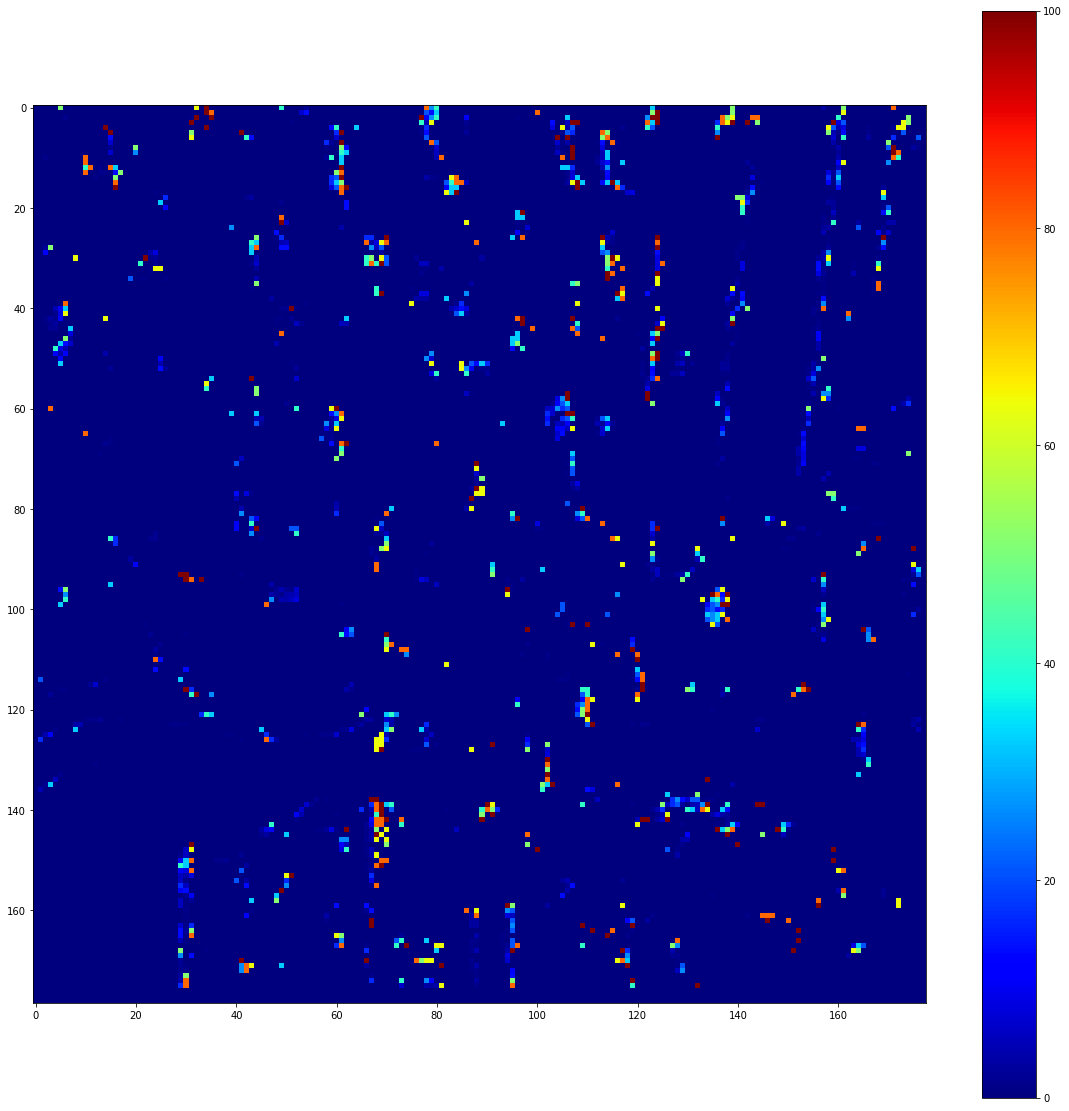

In [2]:
plt.figure(figsize=(20, 20))
m = plt.imshow(np.delete(np.sum(data, axis=-1), 0, 1), cmap="jet")
plt.colorbar(m)

In [3]:
data_dir

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [4]:
input_directions = np.zeros((n_directions, data_steps))
print(t_start)
for t in range(data_steps):
    
    t_real = t_start + t * (duration / data_steps)
    
    t_dif = t_real - directions[:,0]
    t_dif_m = np.ma.masked_where(t_dif < 0, t_dif)
    
    idx = t_dif_m.argmin()

    input_directions[int(directions[idx, 1]), t] = 6

1.600000952


In [5]:
input_directions

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [6]:
u = data_u["Process_64"]["u"]

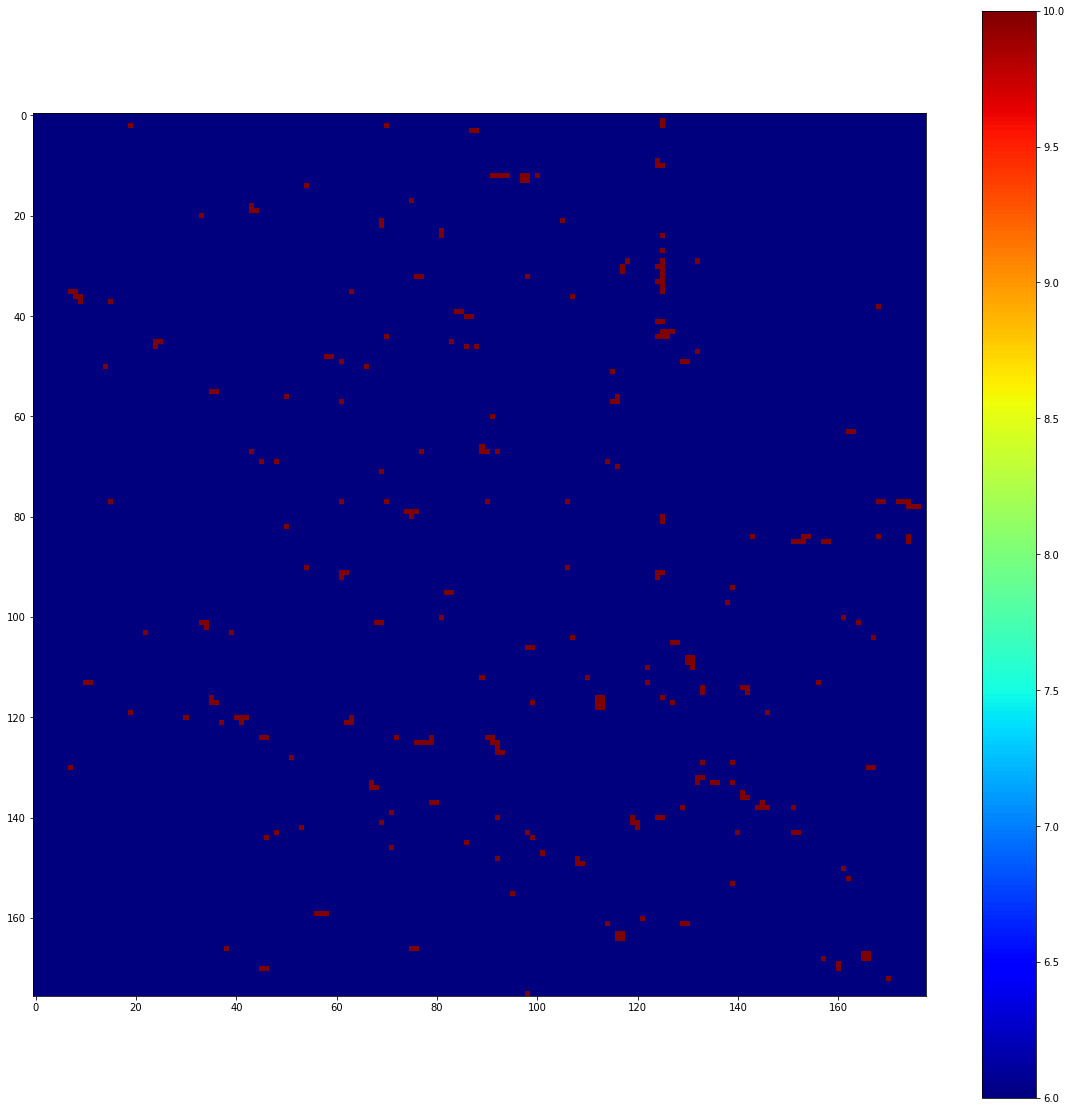

In [7]:
plt.figure(figsize=(20, 20))
m = plt.imshow(u[0,:,:], cmap="jet")
plt.colorbar(m)

In [8]:
data_u

{'Process_64': {'u': array([[[ 6.,  6.,  6., ...,  6.,  6.,  6.],
          [ 6.,  6.,  6., ...,  6.,  6.,  6.],
          [ 6.,  6.,  6., ...,  6.,  6.,  6.],
          ...,
          [ 6.,  6.,  6., ...,  6.,  6.,  6.],
          [ 6.,  6.,  6., ...,  6.,  6.,  6.],
          [ 6.,  6.,  6., ...,  6.,  6.,  6.]],
  
         [[ 6.,  6.,  6., ...,  6.,  6.,  6.],
          [ 6.,  6.,  6., ...,  6.,  6.,  6.],
          [ 6.,  6.,  6., ...,  6.,  6.,  6.],
          ...,
          [ 6., 10., 10., ...,  6.,  6.,  6.],
          [ 6.,  6., 10., ...,  6.,  6.,  6.],
          [ 6.,  6.,  6., ...,  6.,  6.,  6.]],
  
         [[ 6.,  6.,  6., ...,  6.,  6.,  6.],
          [ 6.,  6.,  6., ...,  6., 10., 10.],
          [ 6.,  6.,  6., ...,  6.,  6.,  6.],
          ...,
          [ 6.,  6.,  6., ...,  6.,  6.,  6.],
          [ 6.,  6.,  6., ...,  6.,  6.,  6.],
          [ 6.,  6.,  6., ...,  6.,  6.,  6.]],
  
         ...,
  
         [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
          [ 0.

In [9]:
u.shape

(50, 176, 178)